In [1]:
import glob
import os
import time
import csv

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID' 
os.environ['CUDA_VISIBLE_DEVICES']='1'

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.autograd import Variable
import torch.autograd as autograd
import torchvision.utils as vutils

from torch.utils.data import DataLoader, TensorDataset

In [2]:
def load_data():
    x_train = (h5py.File('camelyonpatch_level_2_split_train_x.h5', 'r')['x'][:, 16:80,16:80] - 127.5) / 127.5
    y_train = h5py.File('camelyonpatch_level_2_split_train_y.h5', 'r')['y'][:].reshape(-1,1)
    x_test = (h5py.File('camelyonpatch_level_2_split_test_x.h5', 'r')['x'][:, 16:80,16:80] - 127.5) / 127.5
    y_test = h5py.File('camelyonpatch_level_2_split_test_y.h5', 'r')['y'][:].reshape(-1,1)
    x_valid = (h5py.File('camelyonpatch_level_2_split_valid_x.h5', 'r')['x'][:, 16:80,16:80] - 127.5) / 127.5
    y_valid = h5py.File('camelyonpatch_level_2_split_valid_y.h5', 'r')['y'][:].reshape(-1,1)
              
    return x_train, y_train, x_test, y_test, x_valid, y_valid

def plot_samples(samples, folder=None, epoch=None, i=None):
    rt = int(np.sqrt(samples.shape[0]))
    r, c = rt, rt
    # r, c = 6, 12

    generatedImage = 0.5 * samples + 0.5

    fig = plt.figure(figsize=(10,10))

    axs = [fig.add_subplot(r,c,i+1) for i in range(r*c)]
    cnt = 0
    for ax in axs:
        ax.imshow(generatedImage[cnt],interpolation='nearest')
        ax.axis('off')
        ax.set_aspect('equal')
        cnt+=1
    fig.subplots_adjust(wspace=.004, hspace=.02)

    if folder:
        path = 'results/'+folder+'/samples'
        if not os.path.exists('results'):
            os.mkdir('results')
        if not os.path.exists('results/'+folder):
            os.mkdir('results/'+folder)
        if not os.path.exists(path):
            os.mkdir(path)
        step = ""
        if i:
            step = '_'+str(i)
        fig.savefig(path+'/epoch_%d%s.png' % (epoch, step))
        plt.close()


In [3]:
%cd "~/pathology_gan"

x_train, y_train, x_test, y_test, x_valid, y_valid = load_data()

# x_train = torch.from_numpy(np.moveaxis(x_train.astype(np.float32), -1, 1))
# x_test  = torch.from_numpy(np.moveaxis(x_test.astype(np.float32), -1, 1))
# x_valid  = torch.from_numpy(np.moveaxis(x_valid.astype(np.float32), -1, 1))

# y_train = torch.from_numpy(y_train).float() 
# y_test = torch.from_numpy(y_test).float() 
# y_valid = torch.from_numpy(y_valid).float() 

X_train = torch.from_numpy(np.moveaxis(np.concatenate([x_train, x_test, x_valid]).astype(np.float32), -1, 1))
# y = torch.from_numpy(np.concatenate([y_train, y_test, y_valid]))

trainloader = DataLoader(X_train, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
# validloader = DataLoader(TensorDataset(x_valid, y_valid), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

# percent = int(x_train.shape[0]*.5)
# np.random.seed(17)
# idx_small = np.random.choice(range(x_train.shape[0]), percent, replace=False)

# x_train_small = x_train[idx_small]
# y_train_small = y_train[idx_small]
# trainloader = DataLoader(TensorDataset(x_train_small, y_train_small), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

# plt.hist(y_train_small.numpy(), bins=2)
# print(percent)

/home/aray/pathology_gan


In [4]:
# noise = np.random.normal(0,1,size=(16,100))
# imgs = saved_actor.predict(noise)
# plot_samples(imgs)

# imgs_real = .5+.5*np.moveaxis(x_train[np.random.choice(range(x_train.shape[0]), 12*6, replace=False)], -1, 1)
# plot_samples(x_train[np.random.choice(range(x_train.shape[0]), 12*6, replace=False)])
# print(imgs_real.shape)
# plt.figure(figsize=(24,12))
# plt.imshow(np.transpose(make_grid(torch.from_numpy(imgs_real), nrow=12, ).numpy(), (1, 2, 0)))

In [5]:
class Generator(nn.Module):
    def __init__(self, w, h, c, latent_dim):
        super(Generator, self).__init__()
        
        self.w = w
        self.h = h
        self.c = c
        self.latent_dim = latent_dim
        
#         self.n_filters = 32
        
        self.input = nn.Sequential(
            nn.Linear(latent_dim, 32 * 16 * 16),
            nn.ReLU()
        )
        
        self.deconv = nn.Sequential(
            nn.Upsample(size=[32, 32], mode='nearest'),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(True),
            
            nn.Upsample(size=[64, 64], mode='nearest'),
            nn.Conv2d(64, 48, 4, stride=2, padding=1),
            nn.ReLU(True),
            
            nn.Upsample(size=[64, 64], mode='nearest'),
            nn.Conv2d(48, 32, 3, stride=1, padding=1),
            nn.ReLU(True),

            nn.Upsample(size=[128, 128], mode='nearest'),
            nn.Conv2d(32, 16, 4, stride=2, padding=1),
            nn.ReLU(True),

#             nn.Upsample(size=[128, 128], mode='nearest'),
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.ReLU(True),

            nn.Upsample(size=[128, 128], mode='nearest'),
            nn.Conv2d(8, 16, 4, stride=2, padding=1),
            nn.ReLU(True),
            
            nn.Conv2d(16, c, 3, stride=1, padding=1),
            nn.Tanh()            
        )

    def forward(self, x):
        output = self.input(x)
        # print(output.shape)
        output = output.view(-1, 32, 16, 16)
        # print(output.shape)
        return self.deconv(output) #.view(-1, self.w, self.h, self.c)

class Discriminator(nn.Module):
    def __init__(self, h, w, c):
        super(Discriminator, self).__init__()
        
        self.w = w
        self.h = h
        self.c = c
        n_filters = 32

        self.conv = nn.Sequential(
            nn.Conv2d(c, n_filters, 4, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(p=0.15),

            nn.Conv2d(n_filters, 2*n_filters, 4, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(p=0.15),
            
            nn.Conv2d(2*n_filters, 4*n_filters, 4, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(p=0.15),
            
            nn.Flatten(),
            
            nn.Linear(4*n_filters*int(w/2**3)*int(h/2**3), 256, bias=True),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.15),
            
            nn.Linear(256, 1, bias=True)
        )

    def forward(self, x):
        return self.conv(x)



In [8]:
class SSL_WGAN:
    def __init__(self, w, h, c, model_name, latent_dim=100):
        self.model_name = model_name
        self.latent_dim = latent_dim 
        self.lambda_gp = 10
        self.lambda_ct = 2
        self.d_iterations = 5
        self.print_every = 10
        # CT multiplier
        self.M = .1
        self.use_cuda = True
        self.D = Discriminator(w, h, c)
        self.G = Generator(w, h, c, latent_dim)

#         lr = 1e-4
#         betas = (.0, .99)

#         self.D_opt = optim.Adam(self.D.parameters(), lr=lr, betas=betas)
#         self.G_opt = optim.Adam(self.G.parameters(), lr=lr, betas=betas)

        self.D_opt = optim.RMSprop(self.D.parameters(), lr=0.00005)
        self.G_opt = optim.RMSprop(self.G.parameters(), lr=0.00005)

        if self.use_cuda:
            self.D = self.D.cuda()
            self.G = self.G.cuda()

        if not os.path.exists('results/'+model_name):
            os.mkdir('results/'+model_name)

    def train(self, train_loader, epochs, save_training_gif=True):
#         print(n_samples, n_samples//128)
        if save_training_gif:
            # Fix latents to see how image generation improves during training
            self.fixed_latents = torch.randn((12*6, self.latent_dim))
            if self.use_cuda:
                self.fixed_latents = self.fixed_latents.cuda()
            self.training_progress_images = []

        self.stats = {
            'g_loss': [],
            'd_loss': [],
            'd_loss_real': [],
            'd_loss_fake': [],
            'gp': [],
        }

        for epoch in range(epochs):
            g_loss = []
            d_loss = []
            d_loss_fake = []
            d_loss_real = []
            gradient_penalty = []

#             for i, data in tqdm(enumerate(train_loader), desc="epoch "+str(epoch)):
            for i, X in enumerate(train_loader):
#                 if i%((n_samples//128)//100)==0:
#                     print(".", end="", flush=True)
                if self.use_cuda:
                    X = X.cuda()
                
                loss, gp = self._train_D(X)
#                 d_loss_real.append(r)
#                 d_loss_fake.append(g)
                gradient_penalty.append(gp)
                d_loss.append(loss)
                
                # Only update generator every |d_iterations| iterations
#                 if i % self.d_iterations == 0:
                g_loss.append(self._train_G(X.shape[0]))
            
#             if epoch % 10 == 0:
            g_loss_m = sum(g_loss)/len(g_loss)
            d_loss_m = sum(d_loss)/len(d_loss)
#                 real_m = sum(d_loss_real)/len(d_loss_real)
#                 fake_m = sum(d_loss_fake)/len(d_loss_fake)
            gp_m = sum(gradient_penalty)/len(gradient_penalty)
            self.stats['g_loss'].append(g_loss_m)
            self.stats['d_loss'].append(d_loss_m)
#                 self.stats['d_loss_real'].append(real_m)
#                 self.stats['d_loss_fake'].append(fake_m)
            self.stats['gp'].append(gp_m)
            print("Epoch: %d, G loss: %f"%(epoch, g_loss_m))
            print("D loss: %f; gp: %f"%(d_loss_m, gp_m))
            
#             if epoch % 10 == 0:
            with torch.no_grad():
                self.G.eval()
#                     self.D.eval()
#                     print(self.D(X_unlabled[:10].cuda()).view(-1))
#                     self.D.train()
                imgs = self.G(torch.randn((16, self.latent_dim)).cuda()).cpu().numpy()
                plot_samples(np.moveaxis(imgs, 1,-1), self.model_name, epoch)
                self.G.train()

#             if  epoch % 10 == 0 and save_training_gif:
            with torch.no_grad():
                self.G.eval()
                img_grid = vutils.make_grid(self.G(self.fixed_latents).cpu(), nrow=12).numpy()
                # (width, height, channels)
                img_grid = .5+.5*np.transpose(img_grid, (1, 2, 0))
                self.training_progress_images.append(img_grid)
                self.G.train()

            # if i % self.print_every == 0:
            #     print("Iteration {}".format(i + 1))
            #     print("D: {}".format(self.losses['D'][-1]))
            #     print("GP: {}".format(self.losses['GP'][-1]))
            #     print("Gradient norm: {}".format(self.losses['gradient_norm'][-1]))
            #     if self.num_steps > self.critic_iterations:
            #         print("G: {}".format(self.losses['G'][-1]))

        if save_training_gif:
            imageio.mimsave('results/'+self.model_name+'/training_{}_epochs.gif'.format(epochs), self.training_progress_images)

    def _train_D(self, data):
        self.D_opt.zero_grad()
        
        generated_data = self.sample_generator(data.shape[0])

        real = self.D(data)
        gen = self.D(generated_data)

        
        gp = self._gradient_penalty(data, generated_data)

        d_loss = gen.mean() - real.mean() + gp
        
        d_loss.backward()
        self.D_opt.step()

        return d_loss.detach().item(), gp.detach().item()
    
    def _train_G(self, batch_size):
        for p in self.D.parameters():
            p.requires_grad = False
            
        self.G_opt.zero_grad()

        generated_data = self.sample_generator(batch_size)
        gen = self.D(generated_data)

        g_loss = -gen.mean()
        
        g_loss.backward()
        self.G_opt.step()
        
        for p in self.D.parameters():
            p.requires_grad = True

        return g_loss.detach().item()    

    def _gradient_penalty(self, real_data, generated_data):
        batch_size = real_data.shape[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        # interpolated = Variable(interpolated, requires_grad=True)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        dis_interpolated = self.D(interpolated)
        grad_outputs = torch.ones(dis_interpolated.shape)
        if self.use_cuda:
            grad_outputs=grad_outputs.cuda()

        # Calculate gradients of probabilities with respect to examples
        gradients = autograd.grad(outputs=dis_interpolated, inputs=interpolated,
                               grad_outputs=grad_outputs, create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)
#         self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data[0])

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = ((torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12) - 1) ** 2).mean()
        # Return gradient penalty
        return self.lambda_gp*gradients_norm #((gradients.norm(2, dim=1) - 1) ** 2).mean()

#     def _consistency_term(self, real_data):
#         d1, d_1 = self.D(real_data, clf=False)
#         d2, d_2 = self.D(real_data, clf=False)

# #         ct = (d1 - d2).norm(2, dim=1) + 0.1 * (d_1 - d_2).norm(2, dim=1) - self.M
#         ct = self.lambda_ct*((d1.view(-1) - d2.view(-1))**2+0.1*((d_1.view(-1) - d_2.view(-1))**2).mean()) - self.M
#         return torch.max(ct, torch.zeros_like(ct)).mean()
        
    def sample_generator(self, num_samples):
        latent_samples = torch.randn((num_samples, self.latent_dim), requires_grad=True)
        if self.use_cuda:
            latent_samples = latent_samples.cuda()
        generated_data = self.G(latent_samples)
        return generated_data

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        # Remove color channel
        return generated_data.data.cpu().numpy()[:, 0, :, :]

In [ ]:
wgan_ct = SSL_WGAN(64, 64, 3, 'wgan_gp_4')
wgan_ct.train(trainloader, 10000)
# save_stats(wgan_ct)
# save_plots(wgan_ct)

Epoch: 0, G loss: -5.453918
D loss: -26.537164; gp: 12.591747


In [8]:
def save_stats(model):
    with open('results/'+model.model_name+'/clf_acc.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.stats['clf_acc'])

    with open('results/'+model.model_name+'/clf_loss.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.stats['clf_loss'])

    with open('results/'+model.model_name+'/clf_acc_val.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.stats['clf_acc_val'])
        
    with open('results/'+model.model_name+'/d_loss.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.stats['d_loss'])

    with open('results/'+model.model_name+'/g_loss.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.stats['g_loss'])

    with open('results/'+model.model_name+'/ct.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.stats['ct'])
        
    with open('results/'+model.model_name+'/gp.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.stats['gp'])

def save_plots(model):
    path = 'results/'+model.model_name
    
    fig = plt.figure(figsize=(18,5))
    plt.plot(wgan_ct.stats['ct'], label='CT')
    plt.xlabel('Epochs x10')
    plt.ylabel('Loss')
    plt.legend()
    fig.savefig(path+'/ct.png')

    fig = plt.figure(figsize=(18,5))
    plt.plot(wgan_ct.stats['d_loss'], label='D')
    plt.plot(wgan_ct.stats['g_loss'], label='G')
    plt.xlabel('Epochs x10')
    plt.ylabel('Loss')
    plt.legend()
    fig.savefig(path+'/gan_loss.png')

    fig = plt.figure(figsize=(18,5))
    plt.plot(wgan_ct.stats['clf_loss'], label='Clf train')
    plt.xlabel('Epochs x10')
    plt.ylabel('Loss')
    plt.legend()
    fig.savefig(path+'/clf_train_loss.png')

    fig = plt.figure(figsize=(18,5))
    acc_max = np.max(wgan_ct.stats['clf_acc_val'])
    acc_max_e = np.argmax(wgan_ct.stats['clf_acc_val'])
    plt.axhline(y=acc_max, color='k', linestyle='-', alpha=0.2, linewidth=1)
    plt.axvline(x=acc_max_e, color='k', linestyle='-', alpha=0.2, linewidth=1)
    plt.plot(wgan_ct.stats['clf_acc'], label='Train')
    plt.plot(wgan_ct.stats['clf_acc_val'], label='Validation')
    plt.xlabel('Epochs x10')
    plt.ylabel('Acc')
    plt.legend()
    fig.savefig(path+'/clf_acc.png')


In [35]:
def load_clf(name):
    with open('results/ssl_wgan3_'+name+'/clf_acc_val.csv', newline='') as f:
        reader = csv.reader(f)
        sslclf = list(reader)
        sslclf = [float(r) for r in sslclf[0]]
    with open('results/clf/clf_acc_val'+name+'.csv', newline='') as f:
        reader = csv.reader(f)
        clf= list(reader)
        clf =  [float(r) for r in clf[0]]
    return np.array(sslclf), np.array(clf)

In [36]:
ssl01, clf01 = load_clf('01')
ssl10, clf10 = load_clf('10')
ssl25, clf25 = load_clf('25')
ssl50, clf50 = load_clf('50')
ssl80, clf80 = load_clf('80')
ssl100, clf100 = load_clf('100')

In [63]:
ssl01_max, clf01_max = max(ssl01), max(clf01) 
ssl10_max, clf10_max = max(ssl10), max(clf10) 
ssl25_max, clf25_max = max(ssl25), max(clf25) 
ssl50_max, clf50_max = max(ssl50), max(clf50) 
ssl80_max, clf80_max = max(ssl80), max(clf80) 
ssl100_max, clf100_max = max(ssl100), max(clf100)

ssl_max = np.array([ssl01_max, ssl10_max, ssl25_max, ssl50_max, ssl80_max, ssl100_max])
clf_max = np.array([clf01_max, clf10_max, clf25_max, clf50_max, clf80_max, clf100_max])

In [64]:
ssl01_avg, clf01_avg = ssl01.mean(), clf01.mean() 
ssl10_avg, clf10_avg = ssl10.mean(), clf10.mean() 
ssl25_avg, clf25_avg = ssl25.mean(), clf25.mean() 
ssl50_avg, clf50_avg = ssl50.mean(), clf50.mean() 
ssl80_avg, clf80_avg = ssl80.mean(), clf80.mean() 
ssl100_avg, clf100_avg = ssl100.mean(), clf100.mean()

ssl_avg = np.array([ssl01_avg, ssl10_avg, ssl25_avg, ssl50_avg, ssl80_avg, ssl100_avg])
clf_avg = np.array([clf01_avg, clf10_avg, clf25_avg, clf50_avg, clf80_avg, clf100_avg])

In [89]:
ssl01_avg, clf01_avg = ssl01[10:].mean(), clf01[10:].mean() 
ssl10_avg, clf10_avg = ssl10[10:].mean(), clf10[10:].mean() 
ssl25_avg, clf25_avg = ssl25[10:].mean(), clf25[10:].mean() 
ssl50_avg, clf50_avg = ssl50[10:].mean(), clf50[10:].mean() 
ssl80_avg, clf80_avg = ssl80[10:].mean(), clf80[10:].mean() 
ssl100_avg, clf100_avg = ssl100[10:].mean(), clf100[10:].mean()

ssl_avg1 = np.array([ssl01_avg, ssl10_avg, ssl25_avg, ssl50_avg, ssl80_avg, ssl100_avg])
clf_avg1 = np.array([clf01_avg, clf10_avg, clf25_avg, clf50_avg, clf80_avg, clf100_avg])

In [79]:
def plot_bar(ssl, clf, name):
    ind = np.arange(len(ssl_max))
    width = 0.3       

    plt.figure(figsize=(18,5))
    plt.bar(ind, ssl-.5 , width, label='SSL')
    plt.bar(ind + width, clf-.5, width, label='CLF')

    plt.xlabel('% of dataset')
    plt.ylabel('Acc')
    plt.title(name+' SSL vs CNN classifier')

    plt.xticks(ind + width / 2, ('1%', '10%', '25%', '50%', '80%', '100%'))
    plt.yticks(np.arange(0, .35, step=0.11), np.arange(.5, .85, step=0.11))
    plt.legend()


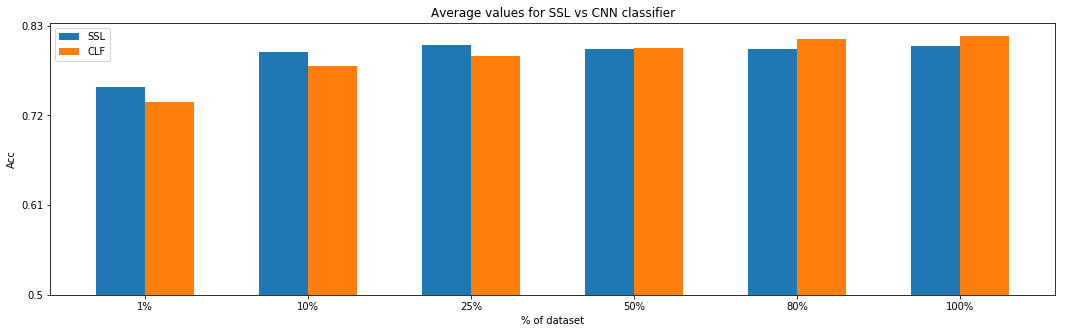

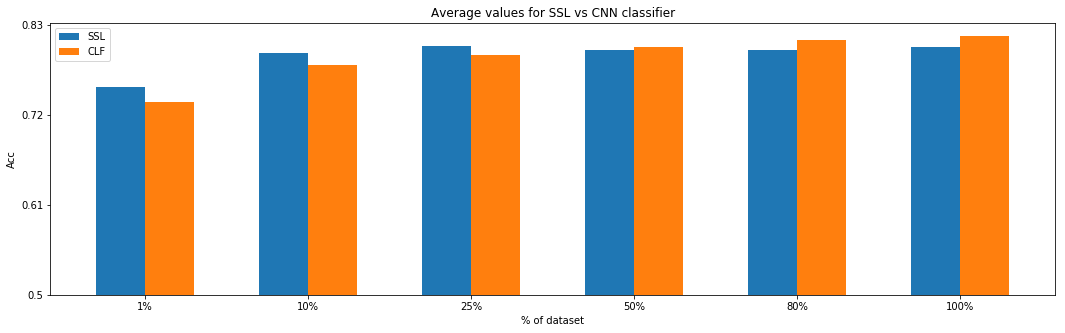

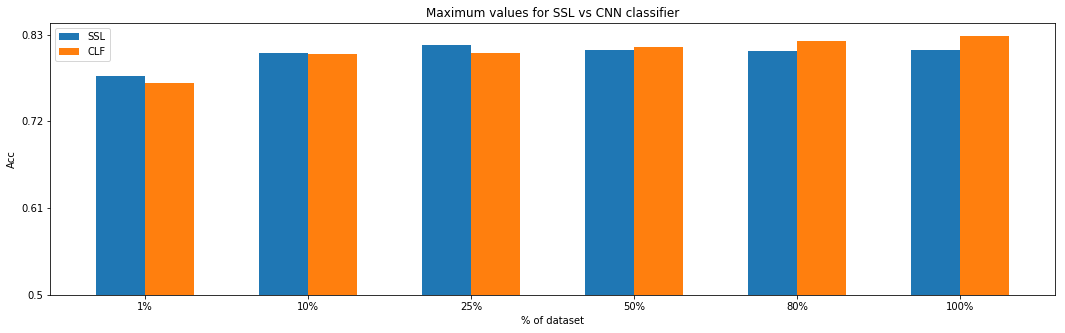

In [90]:
plot_bar(ssl_avg1, clf_avg1, 'Average values for')
plot_bar(ssl_avg, clf_avg, 'Average values for')
plot_bar(ssl_max, clf_max, 'Maximum values for')

In [81]:
def plot_stats(ssl, clf, title):
    plt.figure(figsize=(18,5))
#     acc_max = np.max(wgan_ct.stats['clf_acc_val'])
#     acc_max_e = np.argmax(wgan_ct.stats['clf_acc_val'])
#     plt.axhline(y=acc_max, color='k', linestyle='-', alpha=0.2, linewidth=1)
#     plt.axvline(x=acc_max_e, color='k', linestyle='-', alpha=0.2, linewidth=1)
    plt.title(title+'% of dataset')
    plt.plot(ssl, label='SSL')
    plt.plot(clf, label='CLF')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()

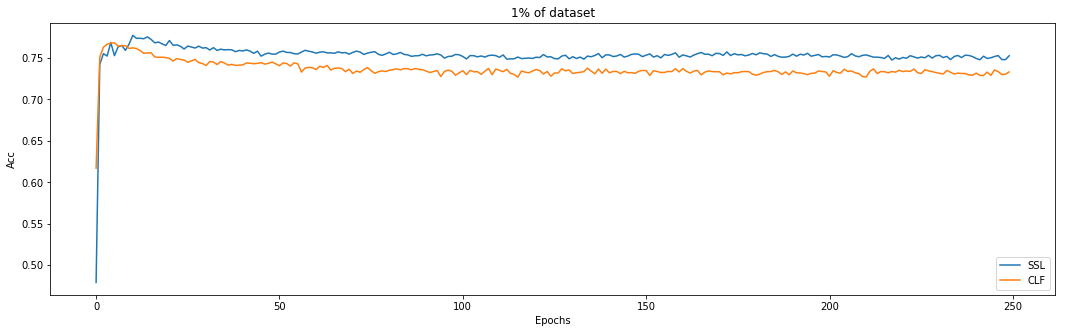

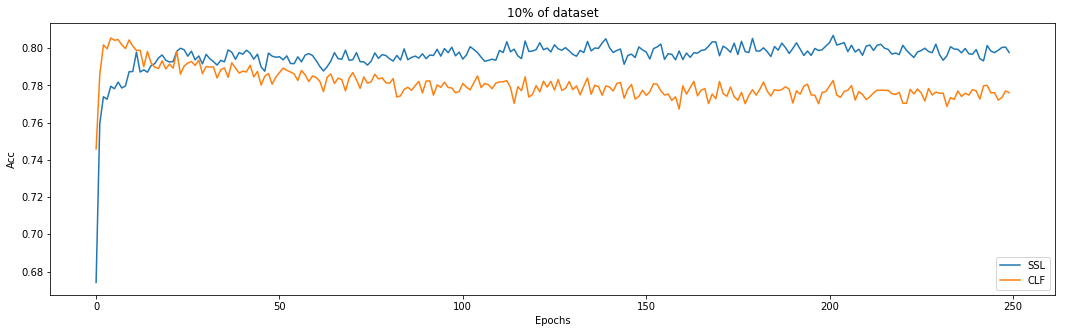

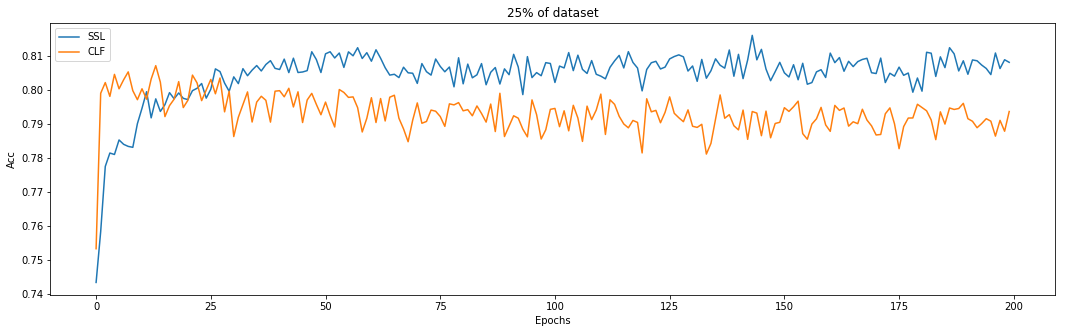

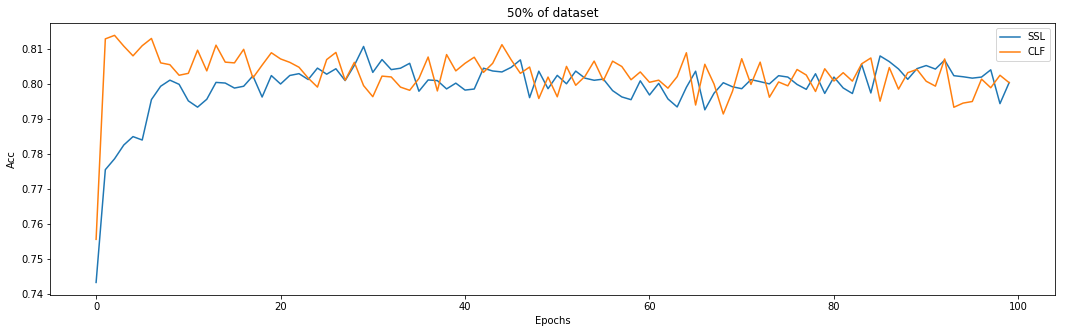

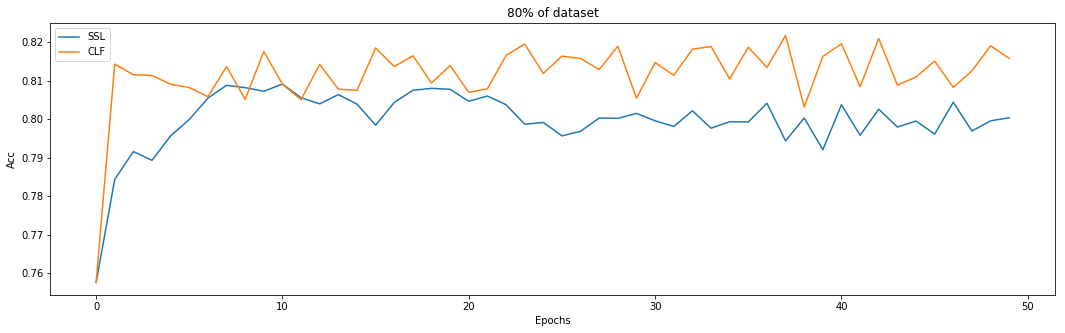

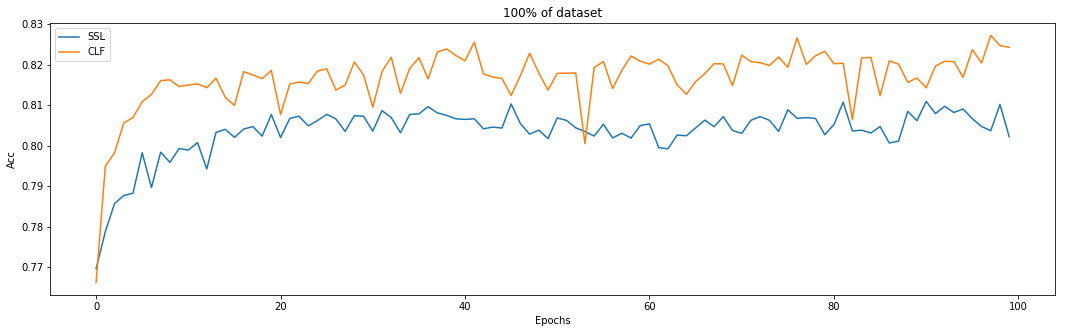

In [88]:
plot_stats(ssl01, clf01, '1')
plot_stats(ssl10, clf10, '10')
plot_stats(ssl25, clf25[:200], '25')
plot_stats(ssl50, clf50[::2][:100], '50')
plot_stats(ssl80[::2], clf80, '80')
plot_stats(ssl100, clf100[::5], '100')

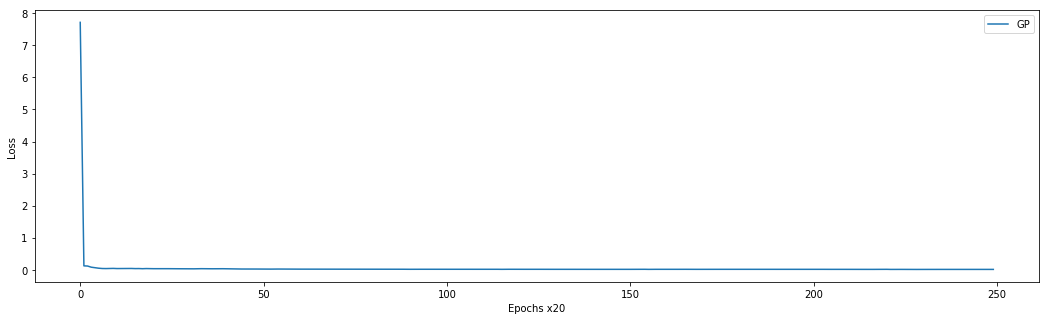

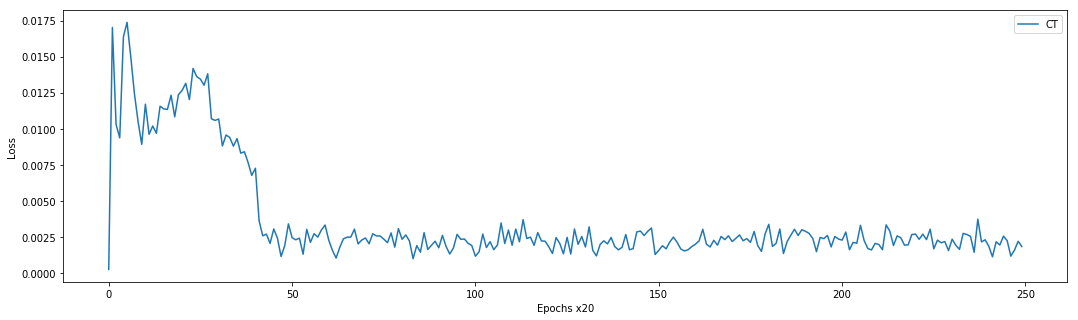

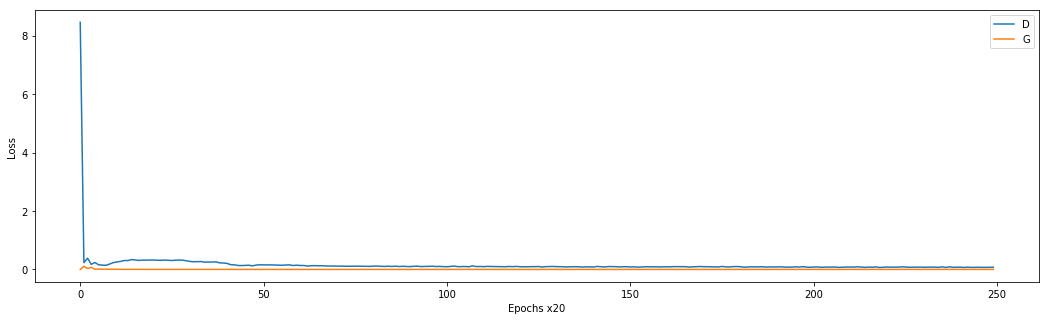

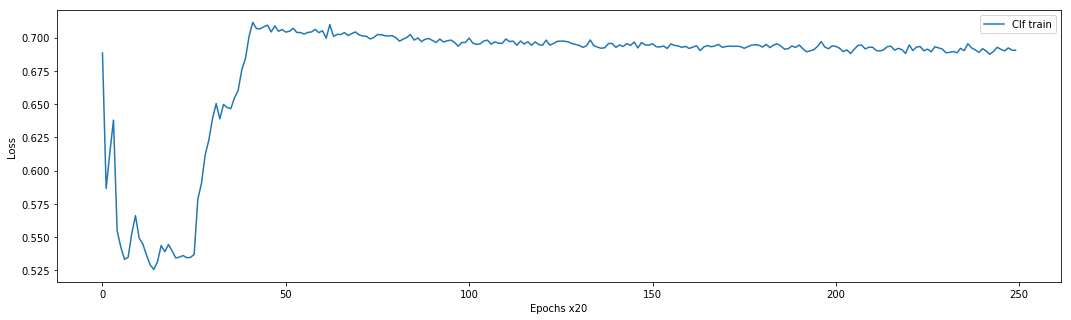

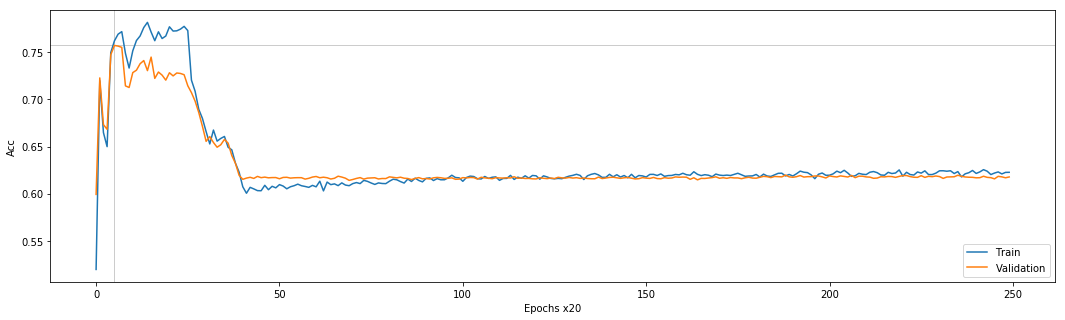

In [16]:
plt.figure(figsize=(18,5))
plt.plot(wgan_ct.stats['gp'], label='GP')
plt.xlabel('Epochs x20')
plt.ylabel('Loss')
plt.legend()


plt.figure(figsize=(18,5))
plt.plot(wgan_ct.stats['ct'], label='CT')
plt.xlabel('Epochs x20')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(18,5))
plt.plot(wgan_ct.stats['d_loss'], label='D')
plt.plot(wgan_ct.stats['g_loss'], label='G')
plt.xlabel('Epochs x20')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(18,5))
plt.plot(wgan_ct.stats['clf_loss'], label='Clf train')
plt.xlabel('Epochs x20')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(18,5))
acc_max = np.max(wgan_ct.stats['clf_acc_val'])
acc_max_e = np.argmax(wgan_ct.stats['clf_acc_val'])
plt.axhline(y=acc_max, color='k', linestyle='-', alpha=0.2, linewidth=1)
plt.axvline(x=acc_max_e, color='k', linestyle='-', alpha=0.2, linewidth=1)
plt.plot(wgan_ct.stats['clf_acc'], label='Train')
plt.plot(wgan_ct.stats['clf_acc_val'], label='Validation')
plt.xlabel('Epochs x20')
plt.ylabel('Acc')
plt.legend()

In [8]:
wgan_ct._consistency_term(X[:10].cuda())

tensor(0.5439, device='cuda:0', grad_fn=<MeanBackward0>)

In [11]:
data = X[:10].cuda()
d1, d_1 = wgan_ct.D(data)
d2, d_2 = wgan_ct.D(data)

In [12]:
print(d1.shape, d_1.shape)

torch.Size([10, 1]) torch.Size([10, 8192])


In [49]:
ct = 2.0*((d1.view(-1) - d2.view(-1))**2+0.1*((d_1.view(-1) - d_2.view(-1))**2).mean())
torch.max(ct,torch.zeros_like(ct)).mean()
ct

tensor([0.0012, 0.0061, 0.0044, 0.0043, 0.0034, 0.0013, 0.0010, 0.0051, 0.0062,
        0.0117], device='cuda:0', grad_fn=<MulBackward0>)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<MaxBackward2>)

In [31]:
((d1.view(-1) - d2.view(-1))**2).sqrt()

tensor([0.0108, 0.0506, 0.0414, 0.0410, 0.0346, 0.0129, 0.0022, 0.0457, 0.0513,
        0.0733], device='cuda:0', grad_fn=<SqrtBackward>)

In [30]:
(d1 - d2).norm(2, dim=1).mean()

tensor(0.0364, device='cuda:0', grad_fn=<MeanBackward0>)

In [19]:
gen = Generator(64,64,3).cuda()
noise = torch.FloatTensor(10, 100).normal_(0, 1).cuda()

data_fake = gen(noise)
data_fake.shape

torch.Size([10, 32768])
torch.Size([10, 128, 16, 16])


torch.Size([10, 3, 64, 64])

In [155]:
dis = Discriminator(64,64,3).cuda()
dis(tmp)[0].shape


torch.Size([10])

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

# ================== main script ======================

netG = Generator()
netG.apply(weights_init)
netD = Discriminator()
netD.apply(weights_init)

print netG
print netD

if use_cuda:
    netD = netD.cuda()
    netG = netG.cuda()

optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.5, 0.9))

one = torch.FloatTensor([1])
mone = one * -1
zero = torch.FloatTensor([0])
if use_cuda:
    one = one.cuda()
    mone = mone.cuda()
    zero = zero.cuda()

def dataset():
    while 1:
        for images,targets in train_loader:
            #print(images)
            yield images
data=dataset()
fixed_noise = Variable(torch.randn(100, NOISE_SZ).cuda(),requires_grad = False)

for iteration in xrange(ITERS):
    ############################
    # (1) Update D network
    ###########################
    netD.train()
    for p in netD.parameters():  
        p.requires_grad = True  
    for iter_d in xrange(CRITIC_ITERS):
        _data = data.next()
        real_data = torch.Tensor(_data)
        if use_cuda:
            real_data = real_data.cuda()
        real_data_v = autograd.Variable(real_data)

        netD.zero_grad()


        # train with fake
        noise = torch.randn(BATCH_SIZE, NOISE_SZ)
        if use_cuda:
            noise = noise.cuda()
        noise_v = autograd.Variable(noise, volatile=True)  
        fake = autograd.Variable(netG(noise_v).data)
        D_fake1_1,D_fake1_2 = netD(fake)
        D_fake1 = D_fake1_1.mean()
        D_fake1.backward((one))

        # train with gradient penalty
        gradient_penalty = calc_gradient_penalty(netD, real_data_v.data, fake.data)
        gradient_penalty.backward()
               
        # train with real
        D_real1_1,D_real1_2 = netD(real_data_v)
        D_real1 = D_real1_1.mean()      
        D_real1.backward((mone),retain_graph=True)
        
        # train with CT penalty
        D_real2_1,D_real2_2 = netD(real_data_v)

        ct_penalty = LAMBDA_2*((D_real1_1-D_real2_1)**2)       
        ct_penalty += LAMBDA_2*0.1*((D_real1_2-D_real2_2)**2).mean(dim=1)
        ct_penalty = torch.max(Variable(torch.zeros(ct_penalty.size()).cuda() if use_cuda else torch.zeros(ct_penalty.size())),ct_penalty-Factor_M)
        ct_penalty = ct_penalty.mean()
        #print(ct_penalty)
        ct_penalty.backward()

        D_cost = -D_real1 + D_fake1 + gradient_penalty + ct_penalty
        #print(-D_real1.data[0] , D_fake1.data[0] , gradient_penalty.data[0] ,ct_penalty.data[0])
        #D_cost.backward()
        Wasserstein_D = D_real1 - D_fake1
        optimizerD.step()

    #if not FIXED_GENERATOR:
        ############################
        # (2) Update G network
        ###########################
    netD.eval()
    for p in netD.parameters():
        p.requires_grad = False  
    netG.zero_grad()

    noise = torch.randn(BATCH_SIZE, NOISE_SZ)
    if use_cuda:
        noise = noise.cuda()
    noisev = autograd.Variable(noise,requires_grad=True) 
    fake = netG(noisev)
    G,_ = netD(fake)
    G = G.mean()
    G.backward(mone)
    G_cost = -G
    optimizerG.step()
    print((iteration,D_cost.data[0],Wasserstein_D.data[0]))
    if iteration%100==0:
        fake = netG(fixed_noise).view(-1, 1,28,28)
        vutils.save_image(fake.data,
                    'fake_samples_epoch_%03d.png' %  iteration,
                    normalize=True)

torch.save(netG.state_dict(), 'netG_mnist.pth')
torch.save(netD.state_dict(), 'netD_mnist.pth')